## Initial Steps for Working with GRIB Dataset in Python

### Step 1: Install Required Libraries
You will need pygrib, xarray, numpy, pandas, and matplotlib.
Use the following command to install them:
!pip install pygrib xarray numpy pandas matplotlib

In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

### Step 2: Load and Explore the GRIB Data

In [2]:
import xarray as xr

# Load the GRIB dataset
data = xr.open_dataset('./era5_spain.grib', engine="cfgrib")

# Print available coordinates
print("Coordinates of the dataset:")
print(data.coords)

# Optionally, print specific coordinate values
print("\nLatitude values:")
print(data["latitude"].values)

print("\nLongitude values:")
print(data["longitude"].values)

# If the dataset has time:
if "time" in data.coords:
    print("\nTime values:")
    print(data["time"].values)

Ignoring index file './era5_spain.grib.5b7b6.idx' incompatible with GRIB file
skipping variable: paramId==228 shortName='tp'
Traceback (most recent call last):
  File "c:\Users\Ana\anaconda3\Lib\site-packages\cfgrib\dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "c:\Users\Ana\anaconda3\Lib\site-packages\cfgrib\dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1546300800, 1546344000, 1546387200, ..., 1703937600, 1703980800,
       1704024000])) new_value=Variable(dimensions=('time',), data=array([1546279200, 1546322400, 1546365600, ..., 1703916000, 1703959200,
       1704002400]))
skipping variable: paramId==182 shortName='e'
Traceback (most recent call last):
  File "c:\Users\Ana\anaconda3\Lib\site-packages\cfgrib\dataset.py", line 725, in build_dataset_components
    dict_merge(variables, 

Coordinates of the dataset:
Coordinates:
    number               int32 ...
  * time                 (time) datetime64[ns] 2019-01-01 ... 2023-12-31T12:0...
    step                 timedelta64[ns] ...
    surface              float64 ...
  * latitude             (latitude) float64 44.0 43.0 42.0 ... 38.0 37.0 36.0
  * longitude            (longitude) float64 -10.0 -9.0 -8.0 ... 2.0 3.0 4.0
    valid_time           (time) datetime64[ns] ...
    depthBelowLandLayer  float64 ...

Latitude values:
[44. 43. 42. 41. 40. 39. 38. 37. 36.]

Longitude values:
[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.]

Time values:
['2019-01-01T00:00:00.000000000' '2019-01-01T12:00:00.000000000'
 '2019-01-02T00:00:00.000000000' ... '2023-12-30T12:00:00.000000000'
 '2023-12-31T00:00:00.000000000' '2023-12-31T12:00:00.000000000']


## Generate labels for hot days

In [3]:
# Step 1: Restrict the dataset to May–August
data_summer = data.sel(time=data["time"].dt.month.isin([5, 6, 7, 8]))

# Step 2: Extract temperature data (e.g., variable "t2m") for the summer months
temperature_summer = data_summer["t2m"]
# Step 3: Filter temperature measurements at 12:00 within summer months
# Step 3: Filter temperature measurements at 12:00 within summer months
temp_summer_12 = temperature_summer.sel(time=temperature_summer["time"].dt.hour == 12)

# Convert the time to "day" in datetime format with time set to 00:00:00
temp_summer_12 = temp_summer_12.assign_coords(day=temp_summer_12["time"].dt.floor("D"))

# Use "day" as the main dimension
temp_summer_12 = temp_summer_12.swap_dims({"time": "day"}).reset_coords("time", drop=True)

# Step 4: Extract July–August temperatures for percentile calculation
temp_july_aug = temp_summer_12.sel(day=temp_summer_12["day"].dt.month.isin([7, 8]))


# Step 5: Compute the 95th percentile for each location in July–August
percentile_95 = temp_july_aug.quantile(0.95, dim="day")

# Step 6: Label hot days (May–August) based on the 95th percentile
hot_days = temp_summer_12 > percentile_95

# Step 7: Add the "hot_day" label to the summer dataset
data_summer_labeled = data_summer.assign(hot_day=hot_days)

# Optional: Save the labeled dataset for further analysis
# data_summer_labeled.to_netcdf("labeled_summer_dataset.nc")

# Step 8: Verify the results
# print("Summer Dataset with Hot Day Labels:")
# print(data_summer_labeled.where(data_summer_labeled["hot_day"], drop=True))



## Aggregate all measurements of one day under one timestamp

In [4]:
data_summer_00 = data_summer.sel(time=data_summer["time"].dt.hour == 0)
data_summer_12 = data_summer.sel(time=data_summer["time"].dt.hour == 12)

data_summer_00 = data_summer_00.assign_coords(day=data_summer_00["time"].dt.floor("D"))
data_summer_12 = data_summer_12.assign_coords(day=data_summer_12["time"].dt.floor("D"))

data_summer_00 = data_summer_00.swap_dims({"time": "day"}).reset_coords("time", drop=True)
data_summer_12 = data_summer_12.swap_dims({"time": "day"}).reset_coords("time", drop=True)


# Rename variables in each dataset to include their time suffix
data_summer_00 = data_summer_00.rename({var: f"{var}_00" for var in data_summer_00.data_vars})
data_summer_12 = data_summer_12.rename({var: f"{var}_12" for var in data_summer_12.data_vars})
data_summer_00 = data_summer_00.drop_vars("valid_time", errors="ignore")
data_summer_12 = data_summer_12.drop_vars("valid_time", errors="ignore")

# Merge the renamed datasets
data_summer_merged = xr.merge([data_summer_00, data_summer_12])
# data_merged

In [5]:
# Recalculate the percentile with a lower threshold
percentile_95 = temp_july_aug.quantile(0.95, dim="day")
print("65th Percentile Temperature Values:")
print(percentile_95-273)

65th Percentile Temperature Values:
<xarray.DataArray 't2m' (latitude: 9, longitude: 15)>
array([[20.53129883, 20.70343018, 20.98851318, 21.83621826, 22.45810547,
        22.74553223, 22.97792969, 23.84127197, 24.22894287, 35.31433105,
        36.45611572, 36.74200439, 34.33879395, 30.89462891, 34.82364502],
       [20.59396973, 26.62862549, 28.27498779, 28.39962158, 26.42336426,
        27.46981201, 30.28179932, 31.91206055, 30.60926514, 29.95283203,
        27.7137085 , 30.6256958 , 31.91092529, 34.90413818, 26.22731934],
       [20.96104736, 19.94202881, 29.97106934, 30.42561035, 34.55535889,
        34.23448486, 35.31856689, 32.00689697, 34.65469971, 36.66617432,
        36.8118042 , 34.2529541 , 32.20683594, 32.21547852, 26.7420166 ],
       [21.27652588, 20.28623047, 31.16103516, 33.92158203, 33.69681396,
        35.01575928, 32.75421143, 34.97915039, 35.15170898, 34.82012939,
        36.93917236, 30.96690674, 27.84758301, 27.91158447, 27.9960083 ],
       [21.27706299, 21.248352

In [6]:
# Count the number of hot days (True values) in the "hot_day" field
num_hot_days = data_summer_labeled["hot_day"].sum().item()

print(f"Total number of hot days: {num_hot_days}")

# Count the number of hot days (True values) in the "hot_day" field
num_days = data_summer_labeled.dims["day"]
print(f"Total number of days: {num_days}")

# Sum the count of non-NaN values in "t2m" across time, latitude, and longitude
num_data_points = data_summer_labeled["t2m"].notnull().sum().item()
print(f"Total number of data points: {num_data_points}")



Total number of hot days: 2445
Total number of days: 615
Total number of data points: 166050


In [7]:
print("Temp Summer Dimensions:", temp_summer_12.shape)
print("Percentile 95 Shape:", percentile_95.shape)
print("Hot Days Shape:", hot_days.shape)

Temp Summer Dimensions: (615, 9, 15)
Percentile 95 Shape: (9, 15)
Hot Days Shape: (615, 9, 15)


## Calculating the number of 3 day streaks for each location to check if labeling is plausible

Distinct Three-Day Streaks per Location:
<xarray.DataArray 't2m' (latitude: 9, longitude: 15)>
array([[4, 2, 4, 4, 5, 5, 4, 4, 4, 6, 6, 5, 5, 5, 4],
       [5, 7, 3, 5, 3, 3, 5, 3, 5, 7, 4, 5, 3, 6, 3],
       [4, 7, 3, 3, 3, 3, 4, 3, 5, 5, 5, 5, 4, 4, 3],
       [4, 6, 3, 4, 4, 3, 4, 4, 5, 4, 6, 4, 3, 3, 3],
       [6, 6, 6, 4, 4, 4, 4, 6, 5, 5, 3, 3, 3, 4, 5],
       [5, 5, 6, 5, 4, 4, 3, 5, 6, 3, 3, 4, 3, 4, 6],
       [5, 6, 8, 6, 5, 4, 3, 5, 5, 2, 3, 5, 4, 5, 4],
       [3, 5, 4, 4, 4, 5, 4, 2, 2, 4, 3, 5, 3, 4, 2],
       [4, 6, 4, 4, 3, 3, 5, 5, 4, 5, 4, 4, 4, 4, 3]])
Coordinates:
    number               int32 ...
    step                 timedelta64[ns] ...
    surface              float64 ...
  * latitude             (latitude) float64 44.0 43.0 42.0 ... 38.0 37.0 36.0
  * longitude            (longitude) float64 -10.0 -9.0 -8.0 ... 2.0 3.0 4.0
    depthBelowLandLayer  float64 ...
    quantile             float64 0.95


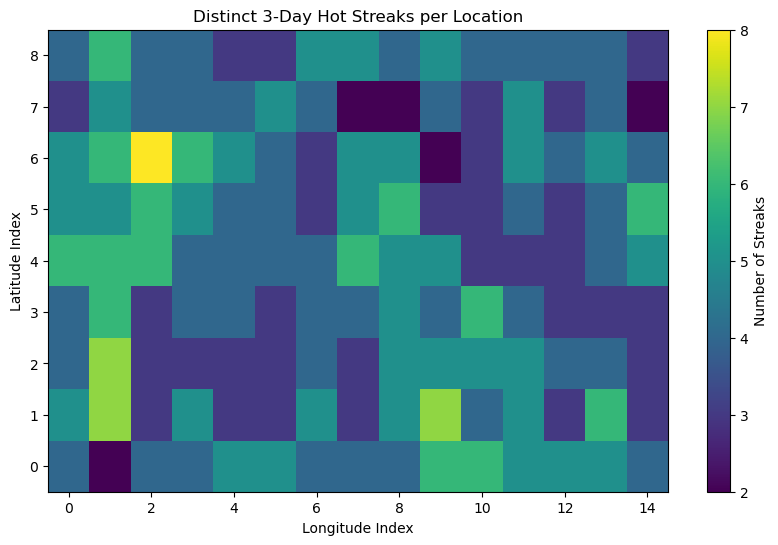

In [8]:
# Step 1: Verify hot days array (already computed)
# print("Hot Days Array (Summary):")
# print(hot_days)

# Step 2: Apply a rolling window to compute streaks
streaks_rolling = (
    hot_days.rolling(day=2, center=False)   # Rolling 3-day window
    .construct("window_dim")                # Create a dimension for the rolling window
    .reduce(np.all, dim="window_dim")       # Check if all values in the window are True
)

# Step 3: Replace NaN values (from rolling) with 0
streaks_rolling_filled = streaks_rolling.fillna(0).astype(int)

# Verify rolling streaks
# print("Rolling Streaks (3-Day):")
# print(streaks_rolling_filled)

# Step 4: Count the number of streaks per location
def count_distinct_streaks(array):
    diff = np.diff(array, axis=0)
    streak_starts = (diff == 1).sum(axis=0)  # Count where a streak begins
    return streak_starts

distinct_streaks = xr.apply_ufunc(
    count_distinct_streaks,
    streaks_rolling_filled,
    input_core_dims=[["day"]],
    vectorize=True
)

# Step 5: Print results
print("Distinct Three-Day Streaks per Location:")
print(distinct_streaks)

# Optional: Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.title("Distinct 3-Day Hot Streaks per Location")
plt.imshow(distinct_streaks, origin="lower", aspect="auto")
plt.colorbar(label="Number of Streaks")
plt.xlabel("Longitude Index")
plt.ylabel("Latitude Index")
plt.show()


## Creating Target labels for each day (if the next 7 days contain at least 3 hot days)

In [9]:
# Define the rolling window size
window_size = 5

# Count the number of hot days in each rolling window
hot_days_rolling = (
    hot_days.rolling(day=window_size, center=False)
    .construct("window_dim")
    .reduce(np.sum, dim="window_dim")
)

# Create labels: 1 if 3 or more hot days, 0 otherwise
labels_next_5_days = (hot_days_rolling >= 2).astype(int)

# Align the labels with the dataset (shift back by window_size - 1)
labels_next_5_days = labels_next_5_days.shift(day=-(window_size - 1))
# Does this makes sense?????

# Drop NaN values (caused by shifting)
labels_next_5_days = labels_next_5_days.dropna("day")

# Debug: Inspect the rolling sum
print("Rolling sum of hot days over 5-day window:")
print(hot_days_rolling)

# Debug: Inspect the labels before and after shifting
print("Labels before shifting (aligned with future interval):")
print((hot_days_rolling >= 2).astype(int))

print("Labels after shifting (aligned with current day):")
print(labels_next_5_days)

Rolling sum of hot days over 5-day window:
<xarray.DataArray 't2m' (day: 615, latitude: 9, longitude: 15)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 2, 1, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0

## Stacking data of 30 days onto each other and adding labels

In [10]:
# Define the feature window size
feature_window_size = 60

# Create rolling windows for features
features_rolling = (
    data_summer_merged.rolling(day=feature_window_size, center=False)
    .construct("feature_dim")
)

# Drop NaN values caused by rolling
features_rolling = features_rolling.dropna("day")

# Align features and labels based on overlapping days
features_rolling, labels_next_5_days = xr.align(features_rolling, labels_next_5_days, join="inner")

# Ensure features and labels are aligned
labels_next_5_days = labels_next_5_days.sel(day=features_rolling["day"])


## Train/Test split and flattening the arrays so they can be processed by NN
The final array will be 2D. Each record corresponds with one location and one day. This record contains the data of the previous 30 days

In [11]:
# Use data from previous years for training
train_features = features_rolling.sel(day=features_rolling["day"].dt.year < 2023)
train_labels = labels_next_5_days.sel(day=labels_next_5_days["day"].dt.year < 2023)

# Use data from 2023 for testing
test_features = features_rolling.sel(day=features_rolling["day"].dt.year == 2023)
test_labels = labels_next_5_days.sel(day=labels_next_5_days["day"].dt.year == 2023)

In [12]:
stacked_features_train = train_features.stack(location=("latitude", "longitude"))
flattened_features_train = stacked_features_train.to_array(dim="variables").stack(features=("variables", "feature_dim")).transpose("day", "location", "features")
# Reshape into (rows, features) where rows = day × location
X_train = flattened_features_train.values.reshape(flattened_features_train.shape[0] * flattened_features_train.shape[1], -1)

# Check the resulting shape
print("Shape of flattened features (X_train):", X_train.shape)

flattened_labels_train = train_labels.stack(location=("latitude", "longitude"))
aligned_labels_train = flattened_labels_train.sel(day=stacked_features_train["day"])
y_train = aligned_labels_train.values.flatten()  # Flatten into a single column
print("Shape of flattened labels (y_train):", y_train.shape)


stacked_features_test = test_features.stack(location=("latitude", "longitude"))
flattened_features_test = stacked_features_test.to_array(dim="variables").stack(features=("variables", "feature_dim")).transpose("day", "location", "features")
# Reshape into (rows, features) where rows = day × location
X_test = flattened_features_test.values.reshape(flattened_features_test.shape[0] * flattened_features_test.shape[1], -1)

# Check the resulting shape
print("Shape of flattened features (X_test):", X_test.shape)

flattened_labels_test = test_labels.stack(location=("latitude", "longitude"))
aligned_labels_test = flattened_labels_test.sel(day=stacked_features_test["day"])
y_test = aligned_labels_test.values.flatten()  # Flatten into a single column
print("Shape of flattened labels (y_test):", y_test.shape)

Shape of flattened features (X_train): (58455, 840)
Shape of flattened labels (y_train): (58455,)
Shape of flattened features (X_test): (16065, 840)
Shape of flattened labels (y_test): (16065,)


### Using different NN and other models to train and test

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

X_train = flattened_features_train.values.reshape(flattened_features_train.shape[0] * flattened_features_train.shape[1], -1)
y_train = aligned_labels_train.values.flatten()  # Flatten into a single column
# Convert to PyTorch tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_train = (X_train - X_train.mean(dim=0)) / X_train.std(dim=0)

# Convert labels to PyTorch tensor
y_train = torch.tensor(y_train, dtype=torch.float32)

# Define a dataset and data loader
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [14]:
positive_rate = torch.sum(y_train == 1).item() / y_train.size(0)
print(f"Positive rate: {positive_rate}")

Positive rate: 0.03287999315712942


In [15]:
# Define a dataset and data loader
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the model
class HotDayPredictor(nn.Module):
    def __init__(self, input_size):
        super(HotDayPredictor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# Initialize the model
input_size = X_train.shape[1]
model = HotDayPredictor(input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

# Train the model
for epoch in range(30):
    for batch in dataloader:
        features, labels = batch
        predictions = model(features)
        loss = loss_fn(predictions.squeeze(), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming test_features and test_labels are prepared as PyTorch tensors
X_test = flattened_features_test.values.reshape(flattened_features_test.shape[0] * flattened_features_test.shape[1], -1)
y_test = aligned_labels_test.values.flatten()  # Flatten into a single column
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Put the model in evaluation mode
model.eval()

# Make predictions on the test set
with torch.no_grad():
    predictions = model(X_test).squeeze()
    predicted_classes = (predictions > 0.5).float()  # Convert probabilities to binary classes

# Calculate accuracy
accuracy = accuracy_score(y_test.numpy(), predicted_classes.numpy())
precision = precision_score(y_test.numpy(), predicted_classes.numpy())
recall = recall_score(y_test.numpy(), predicted_classes.numpy())
f1 = f1_score(y_test.numpy(), predicted_classes.numpy())
print("Initial NN")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch 1, Loss: 0.004139326978474855
Epoch 2, Loss: 0.016078384593129158
Epoch 3, Loss: 0.023708198219537735
Epoch 4, Loss: 0.07953742146492004
Epoch 5, Loss: 0.0016574676847085357
Epoch 6, Loss: 0.06694217026233673
Epoch 7, Loss: 0.0010105405235663056
Epoch 8, Loss: 0.004386637359857559
Epoch 9, Loss: 0.0005304323276504874
Epoch 10, Loss: 0.0012742888648062944
Epoch 11, Loss: 0.006371739320456982
Epoch 12, Loss: 6.064100830371899e-07
Epoch 13, Loss: 0.014508204534649849
Epoch 14, Loss: 7.95507658040151e-05
Epoch 15, Loss: 1.2432656149030663e-07
Epoch 16, Loss: 0.00024980539456009865
Epoch 17, Loss: 5.2755687647731975e-05
Epoch 18, Loss: 8.713583383723744e-07
Epoch 19, Loss: 6.401383870979771e-05
Epoch 20, Loss: 3.2240457130683353e-06
Epoch 21, Loss: 4.128741056774743e-05
Epoch 22, Loss: 1.4359365195559803e-05
Epoch 23, Loss: 0.017444489523768425
Epoch 24, Loss: 8.906439688871615e-06
Epoch 25, Loss: 0.0009293045150116086
Epoch 26, Loss: 3.828852277365513e-05
Epoch 27, Loss: 0.0009537251

c:\Users\Ana\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
# Define the model
class DeeperHotDayPredictor(nn.Module):
    def __init__(self, input_size):
        super(DeeperHotDayPredictor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.fc(x)


# Initialize the model
input_size = X_train.shape[1]
model = DeeperHotDayPredictor(input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

# Train the model
for epoch in range(30):
    for batch in dataloader:
        features, labels = batch
        predictions = model(features)
        loss = loss_fn(predictions.squeeze(), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming test_features and test_labels are prepared as PyTorch tensors
X_test = flattened_features_test.values.reshape(flattened_features_test.shape[0] * flattened_features_test.shape[1], -1)
y_test = aligned_labels_test.values.flatten()  # Flatten into a single column
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Put the model in evaluation mode
model.eval()

# Make predictions on the test set
with torch.no_grad():
    predictions = model(X_test).squeeze()
    predicted_classes = (predictions > 0.5).float()  # Convert probabilities to binary classes

# Calculate accuracy
accuracy = accuracy_score(y_test.numpy(), predicted_classes.numpy())
precision = precision_score(y_test.numpy(), predicted_classes.numpy())
recall = recall_score(y_test.numpy(), predicted_classes.numpy())
f1 = f1_score(y_test.numpy(), predicted_classes.numpy())
print("Deeper NN")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch 1, Loss: 0.04527583345770836
Epoch 2, Loss: 0.00332006742246449
Epoch 3, Loss: 0.0924607664346695
Epoch 4, Loss: 0.005922854412347078
Epoch 5, Loss: 0.014950478449463844
Epoch 6, Loss: 0.0022053299471735954
Epoch 7, Loss: 0.02456376887857914
Epoch 8, Loss: 0.0006775437504984438
Epoch 9, Loss: 0.007096208166331053
Epoch 10, Loss: 0.05186948552727699
Epoch 11, Loss: 0.2437514364719391
Epoch 12, Loss: 0.019563797861337662
Epoch 13, Loss: 7.536212251579855e-06
Epoch 14, Loss: 7.221901614684612e-05
Epoch 15, Loss: 0.00013295322423800826
Epoch 16, Loss: 0.000720927317161113
Epoch 17, Loss: 0.005418885964900255
Epoch 18, Loss: 3.0809883355686907e-07
Epoch 19, Loss: 1.2433986285032006e-06
Epoch 20, Loss: 0.0028850375674664974
Epoch 21, Loss: 9.637619768909644e-06
Epoch 22, Loss: 4.06182007282041e-05
Epoch 23, Loss: 1.4876474779157434e-05
Epoch 24, Loss: 0.0014118701219558716
Epoch 25, Loss: 0.0008098128600977361
Epoch 26, Loss: 0.00017669123189989477
Epoch 27, Loss: 0.0016301294090226293

c:\Users\Ana\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
# Define the model
class DropoutHotDayPredictor(nn.Module):
    def __init__(self, input_size):
        super(DropoutHotDayPredictor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)


# Initialize the model
input_size = X_train.shape[1]
model = DropoutHotDayPredictor(input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

# Train the model
for epoch in range(30):
    for batch in dataloader:
        features, labels = batch
        predictions = model(features)
        loss = loss_fn(predictions.squeeze(), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming test_features and test_labels are prepared as PyTorch tensors
X_test = flattened_features_test.values.reshape(flattened_features_test.shape[0] * flattened_features_test.shape[1], -1)
y_test = aligned_labels_test.values.flatten()  # Flatten into a single column
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Put the model in evaluation mode
model.eval()

# Make predictions on the test set
with torch.no_grad():
    predictions = model(X_test).squeeze()
    predicted_classes = (predictions > 0.5).float()  # Convert probabilities to binary classes

# Calculate accuracy
accuracy = accuracy_score(y_test.numpy(), predicted_classes.numpy())
precision = precision_score(y_test.numpy(), predicted_classes.numpy())
recall = recall_score(y_test.numpy(), predicted_classes.numpy())
f1 = f1_score(y_test.numpy(), predicted_classes.numpy())
print("Dropout NN")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch 1, Loss: 0.3269689083099365
Epoch 2, Loss: 0.12891553342342377
Epoch 3, Loss: 0.017864761874079704
Epoch 4, Loss: 0.018263155594468117
Epoch 5, Loss: 0.003262767568230629
Epoch 6, Loss: 0.0016873488202691078
Epoch 7, Loss: 0.003068438032642007
Epoch 8, Loss: 0.020575031638145447
Epoch 9, Loss: 0.0008747505489736795
Epoch 10, Loss: 0.0009484556503593922
Epoch 11, Loss: 0.0037534586153924465
Epoch 12, Loss: 0.00021748327708337456
Epoch 13, Loss: 0.036542657762765884
Epoch 14, Loss: 0.0068354057148098946
Epoch 15, Loss: 0.01231868751347065
Epoch 16, Loss: 0.03274988755583763
Epoch 17, Loss: 0.00013904020306654274
Epoch 18, Loss: 0.03676877170801163
Epoch 19, Loss: 0.0002089440677082166
Epoch 20, Loss: 0.00023730506654828787
Epoch 21, Loss: 0.04755295440554619
Epoch 22, Loss: 0.1133546307682991
Epoch 23, Loss: 6.085587301640771e-05
Epoch 24, Loss: 0.010161496698856354
Epoch 25, Loss: 0.006516568828374147
Epoch 26, Loss: 2.520581074350048e-05
Epoch 27, Loss: 0.0018436001846566796
Epoc

c:\Users\Ana\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=10)
model.fit(X_train, y_train)

# Assuming test_features and test_labels are prepared as PyTorch tensors
X_test = flattened_features_test.values.reshape(flattened_features_test.shape[0] * flattened_features_test.shape[1], -1)
y_test = aligned_labels_test.values.flatten()  # Flatten into a single column

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test set
probabilities = model.predict_proba(X_test)[:, 1]

# Probar con diferentes umbrales
thresholds = [0.3, 0.5, 0.8]
for threshold in thresholds:
    predicted_classes = (probabilities > threshold).astype(int)
    accuracy = accuracy_score(y_test, predicted_classes)
    precision = precision_score(y_test, predicted_classes)
    recall = recall_score(y_test, predicted_classes)
    f1 = f1_score(y_test, predicted_classes)
    print(f"Threshold: {threshold}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


Threshold: 0.3, Accuracy: 0.0637, Precision: 0.0637, Recall: 1.0000, F1 Score: 0.1197
Threshold: 0.5, Accuracy: 0.1346, Precision: 0.0655, Recall: 0.9492, F1 Score: 0.1226
Threshold: 0.8, Accuracy: 0.9363, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


c:\Users\Ana\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(data.data_vars)